In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install tensorflow==2.16.1 keras==3.3.3 keras-nlp==0.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install keras-nlp, tensorflow-text==2.19.0 and tensorflow==2.16.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested tensorflow==2.16.1
    tensorflow-text 2.19.0 depends on tensorflow<2.20 and >=2.19.0
    The user requested tensorflow==2.16.1
    tensorflow-text 2.18.1 depends on tensorflow<2.19 and >=2.18.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [34]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

import keras_nlp
import keras
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"KerasNLP version: {keras_nlp.__version__}")

import numpy as np
import pandas as pd
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

TensorFlow version: 2.19.0
Keras version: 3.10.0
KerasNLP version: 0.21.1


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import hstack

In [6]:
class CFG:
    seed = 42
keras.utils.set_random_seed(CFG.seed)

print(f"Random seed set to: {CFG.seed}")

Random seed set to: 42


In [7]:
keras.utils.set_random_seed(CFG.seed)

In [8]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [9]:
# in colab (runtime)
BASE_PATH = ''

# in kaggle
#BASE_PATH = '/kaggle/input/llm-classification-finetuning'

### test data

In [10]:
# Load Test Data
test_df = pd.read_csv(f'{BASE_PATH}test.csv')

# Take the first prompt and response
test_df["prompt"] = test_df.prompt.map(lambda x: eval(x)[0])
test_df["response_a"] = test_df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
test_df["response_b"] = test_df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Show Sample
test_df.head()

<string>:1: SyntaxWarning: invalid escape sequence '\/'


,id,prompt,response_a,response_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


### train data

In [11]:
# Load Train Data
train_df = pd.read_csv(f'{BASE_PATH}train.csv')

In [33]:
# 1. create label 0, 1, 2
label_map = {
    'winner_model_a': 0,
    'winner_model_b': 1,
    'winner_tie': 2
}
winner_columns = ['winner_model_a', 'winner_model_b', 'winner_tie']

train_df['winner'] = train_df[winner_columns].idxmax(axis=1).map(label_map)

from sklearn.model_selection import train_test_split

# seperate dataset
df_train, df_val = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['winner']
)

print(f"Training data shape: {df_train.shape}")
print(f"Validation data shape: {df_val.shape}")
print("\n'winner' column (0, 1, 2) create. data seperate")

Training data shape: (45981, 11)
Validation data shape: (11496, 11)

'winner' column (0, 1, 2) create. data seperate


In [13]:

train_df.head(10)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,winner
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1
5,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic...","[""[Zeus]\nYo, it's the king of the gods on the...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods...",0,1,0,1
6,313413,mixtral-8x7b-instruct-v0.1,vicuna-13b,"[""Why water is not used in bath tub?""]","[""Water is actually used in a bath tub. A bath...","[""Water is not used in a bath tub because it i...",1,0,0,0
7,370945,gemini-pro,claude-2.0,"[""\""Bacteria is life on Mars but a heartbeat i...","[""Dune""]","[""This quote seems to be referencing the debat...",0,1,0,1
8,441448,gpt-3.5-turbo-0613,vicuna-13b,"[""translate to russian the followig sentence ...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...",0,1,0,1
9,481524,gpt-4-0314,gpt-3.5-turbo-0613,"[""From now, you *always* have to talk as if yo...","[""Hewwo! OwO I'm an AI assistant, here to hewp...","[""Hewwo! I'm your new helpful assistant, owo! ...",0,1,0,1


### submission data

In [14]:
submission_df = pd.read_csv(f'{BASE_PATH}sample_submission.csv')

In [15]:

submission_df

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.333333,0.333333,0.333333
1,211333,0.333333,0.333333,0.333333
2,1233961,0.333333,0.333333,0.333333


In [16]:
test_df

,id,prompt,response_a,response_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3 non-null      int64 
 1   prompt      3 non-null      object
 2   response_a  3 non-null      object
 3   response_b  3 non-null      object
dtypes: int64(1), object(3)
memory usage: 228.0+ bytes


In [18]:
print(f"train data shape: {train_df.shape}")
print(f"test data shape: {test_df.shape}")
print(f"sample_submission data shape: {submission_df.shape}")

train data shape: (57477, 10)
test data shape: (3, 4)
sample_submission data shape: (3, 4)


The data available for model training consists of a total of 54,477 samples (row).

In [19]:
print(test_df['prompt'][0])
print(test_df["response_a"][0])
print(test_df["response_b"][0])

I have three oranges today, I ate an orange yesterday. How many oranges do I have?
You have two oranges today.
You still have three oranges. Eating an orange yesterday does not affect the number of oranges you have today.


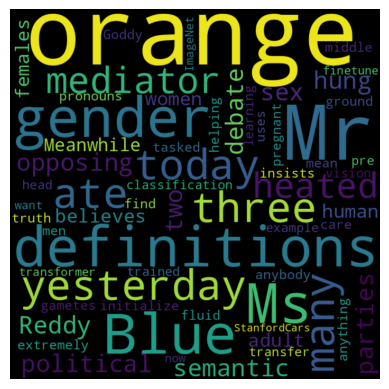

In [20]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=700, height=700).generate(' '.join(test_df['prompt'].dropna()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# data preprocessing

In [21]:
#checking null or missing data
train_df.isnull()
test_df.isnull()
submission_df.isnull()

,id,winner_model_a,winner_model_b,winner_tie
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False


In [22]:
#Check for duplicate data
print(test_df.duplicated().sum())
print(train_df.duplicated().sum())
print(submission_df.duplicated().sum())

0
0
0


In [23]:
#check for duplicate id's
total_id = len(train_df["id"])
total_unique_id = len(train_df["id"].unique())

print("Total number of 'id' duplicates:")
print(total_id - total_unique_id)

Total number of 'id' duplicates:
0


Three binary columns.

winner_model_a: User selected 'Answer A' (Win A)

winner_model_b: User selected 'answer B' (win B)

winner_model_tie: user selected draw (A and B draw)

=> In one row (data), only one of these three becomes 1 and the rest becomes 0. If winnter_model_tie is 1, the user chooses to draw.

model winner: winner_model
winner_model_a    20064
winner_model_b    19652
winner_tie        17761
Name: count, dtype: int64
---------------------------------------
Matplotlib barchart, model winner:


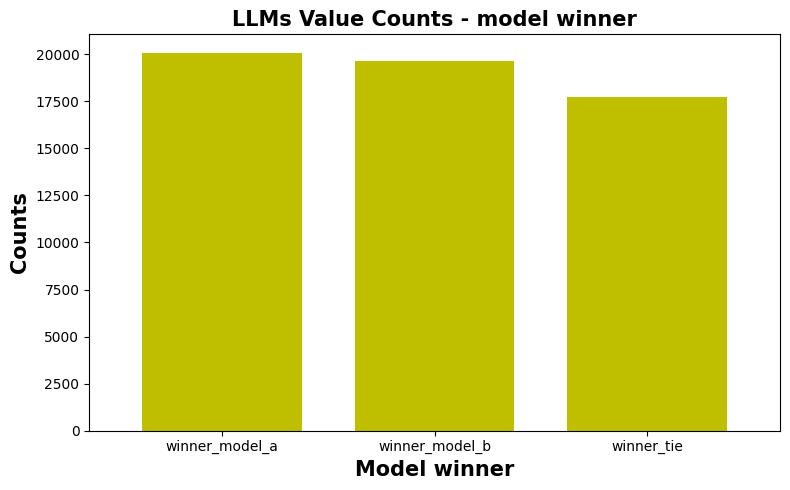

In [24]:
winner_columns = ['winner_model_a', 'winner_model_b', 'winner_tie']

train_df['winner_model'] = train_df[winner_columns].idxmax(axis=1)

result_model_winner = train_df['winner_model'].value_counts()

print("model winner:", result_model_winner)
print("---------------------------------------")

print("Matplotlib barchart, model winner:")
plt.figure(figsize=(8, 5))

result_model_winner.plot(kind='bar', color='y', width=0.75)

plt.ylabel('Counts', fontweight ='bold', fontsize = 15)
plt.xlabel('Model winner', fontweight ='bold', fontsize = 15)
plt.title('LLMs Value Counts - model winner', fontweight ='bold', fontsize = 15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [25]:
train_df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,winner,winner_model
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0,winner_model_a
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1,winner_model_b
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,2,winner_tie
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0,winner_model_a
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1,winner_model_b
...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,0,winner_model_a
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,0,winner_model_a
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,0,winner_model_a
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,1,winner_model_b


## TF-IDF + Logistic Regression

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

all_text_train = pd.concat([df_train["prompt"], df_train["response_a"], df_train["response_b"]])
vectorizer = TfidfVectorizer(max_features=150)
vectorizer.fit(all_text_train)

def vectorize_data(df, vectorizer):
    prompt = vectorizer.transform(df["prompt"])
    resp_a = vectorizer.transform(df["response_a"])
    resp_b = vectorizer.transform(df["response_b"])
    return hstack([prompt, resp_a, resp_b])

X_train_tfidf = vectorize_data(df_train, vectorizer)
X_val_tfidf = vectorize_data(df_val, vectorizer)


y_train = df_train['winner'].values
y_val = df_val['winner'].values

print("Training TF-IDF Logistic Regression...")
model_tfidf = LogisticRegression(max_iter=500, multi_class='multinomial', solver='saga')
model_tfidf.fit(X_train_tfidf, y_train)

print("Evaluating TF-IDF Model...")
preds_proba = model_tfidf.predict_proba(X_val_tfidf)
val_log_loss_tfidf = log_loss(y_val, preds_proba)

print(f"--- Step 1 (TF-IDF) Model ---")
print(f"Validation Log Loss: {val_log_loss_tfidf:.4f}")
print(classification_report(y_val, model_tfidf.predict(X_val_tfidf)))

Training TF-IDF Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluating TF-IDF Model...
--- Step 1 (TF-IDF) Model ---
Validation Log Loss: 1.0661
              precision    recall  f1-score   support

           0       0.44      0.50      0.47      4013
           1       0.43      0.47      0.45      3931
           2       0.42      0.31      0.35      3552

    accuracy                           0.43     11496
   macro avg       0.43      0.43      0.42     11496
weighted avg       0.43      0.43      0.43     11496



The above code is a step for implementing a baseline model.

Converting text data into numeric data (vectors) that machine learning can understand.

Use TF-IDF (low weight for words that are common across the board, high weight for words that are rare in certain areas)
Extract only the top 150(vectorizer = TfidfVectorizer(max_features=150))

The above code is a step of dividing the data into a questionnaire (X) and a correct answer sheet (Y) before training the model

### Test

In [27]:
print("\n=== Test Set Prediction ===")

print("Transforming test data using the TRAINED vectorizer...")
vectorized_test_prompt = vectorizer.transform(test_df["prompt"])
vectorized_test_response_a = vectorizer.transform(test_df["response_a"])
vectorized_test_response_b = vectorizer.transform(test_df["response_b"])

test_X_sparse = hstack([
    vectorized_test_prompt,
    vectorized_test_response_a,
    vectorized_test_response_b
])

print(f"Test X (sparse) shape: {test_X_sparse.shape}")

value_test_y_probabilities = model_tfidf.predict_proba(test_X_sparse)
print('Model winner prediction (probabilities):\n', value_test_y_probabilities)

output = pd.DataFrame({
    'id': test_df.id,
    'winner_model_a': value_test_y_probabilities[:, 0],
    'winner_model_b': value_test_y_probabilities[:, 1],
    'winner_tie': value_test_y_probabilities[:, 2]
})
output.to_csv('submission_logistic_regression.csv', index=False)

print("\n'submission.csv' file is created successfully!")


=== Test Set Prediction ===
Transforming test data using the TRAINED vectorizer...
Test X (sparse) shape: (3, 450)
Model winner prediction (probabilities):
 [[0.23577557 0.2094894  0.55473503]
 [0.46445566 0.24084898 0.29469536]
 [0.26580699 0.39092055 0.34327247]]

'submission.csv' file is created successfully!


## Error and bias analysis

### t-SNE

--- TF-IDF t-SNE---
5000 samples, t-sne execute (takes n minutes.)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE visualization


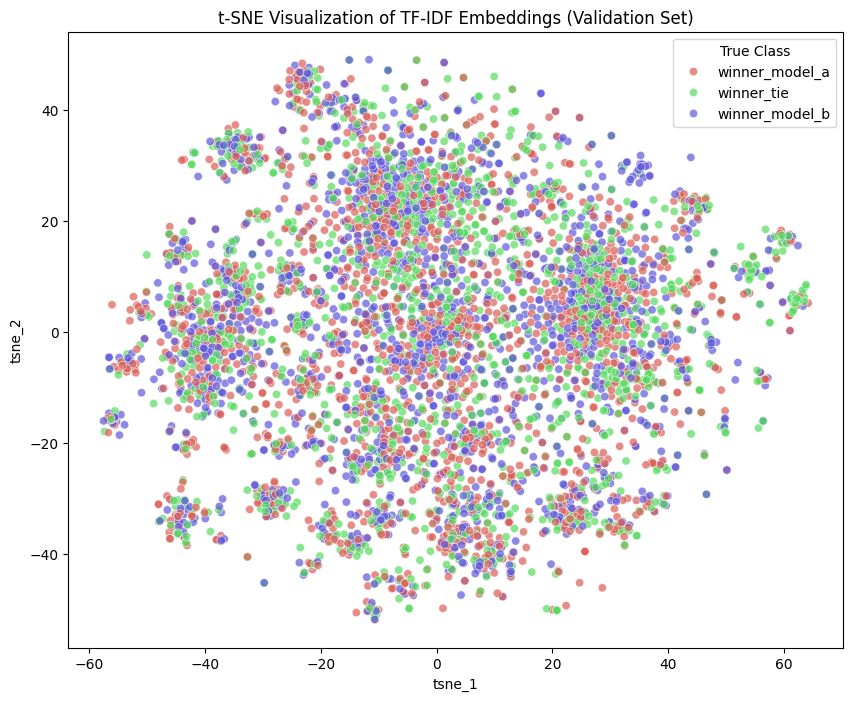

'tsne_tfidf.png' file save


In [32]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

print("--- TF-IDF t-SNE---")

try:
    X_val_dense = X_val_tfidf.toarray()
    y_val_labels = y_val.copy()

    N_SAMPLES = 5000
    if len(y_val_labels) > N_SAMPLES:
        # randome
        indices = np.random.choice(X_val_dense.shape[0], N_SAMPLES, replace=False)
        X_sample = X_val_dense[indices]
        y_sample = y_val_labels[indices]
    else:
        # all use
        X_sample = X_val_dense
        y_sample = y_val_labels

except NameError as e:
    print(f"error: {e}")
    print("before execute this code, you check 'X_val_tfidf' and 'y_val' defined.")
    raise e

print(f"{N_SAMPLES} samples, t-sne execute (takes n minutes.)")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_sample)

# label_map = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
label_to_name_map = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
df_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne['label'] = y_sample
df_tsne['class_name'] = df_tsne['label'].map(label_to_name_map)

print("t-SNE visualization")
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_tsne,
    x='tsne_1',
    y='tsne_2',
    hue='class_name',
    palette=sns.color_palette("hls", 3),
    alpha=0.7
)
plt.title('t-SNE Visualization of TF-IDF Embeddings (Validation Set)')
plt.legend(title='True Class')
plt.savefig('tsne_tfidf.png')
plt.show()

print("'tsne_tfidf.png' file save")

### Silhouette Score

In [31]:
from sklearn.metrics import silhouette_score

print("--- Silhouette Score Calculate ---")

try:
    score = silhouette_score(X_sample, y_sample, metric='cosine')

    print(f"\nSilhouette Score for validation data sample (N={len(y_sample)}): ")
    print(f"Score: {score:.4f}")


except NameError as e:
    print(f"error: {e}")
    print("'X_sample' and 'y_sample' are needed. you execute t-SNE code before this.")
except Exception as e:
    print(f"calculate error: {e}")

--- Silhouette Score Calculate ---

Silhouette Score for validation data sample (N=5000): 
Score: -0.0036


### Confusion matrix

--- 기존 변수를 사용하여 예측값을 생성합니다 ---
예측 생성 완료.

--- 2. 정량 분석 (Classification Report & Confusion Matrix) ---
Classification Report:
                precision    recall  f1-score   support

winner_model_a       0.44      0.50      0.47      4013
winner_model_b       0.43      0.47      0.45      3931
    winner_tie       0.42      0.31      0.35      3552

      accuracy                           0.43     11496
     macro avg       0.43      0.43      0.42     11496
  weighted avg       0.43      0.43      0.43     11496


Confusion matrix(혼동 행렬)가 'confusion_matrix_tfidf.png' 파일로 저장되었습니다.


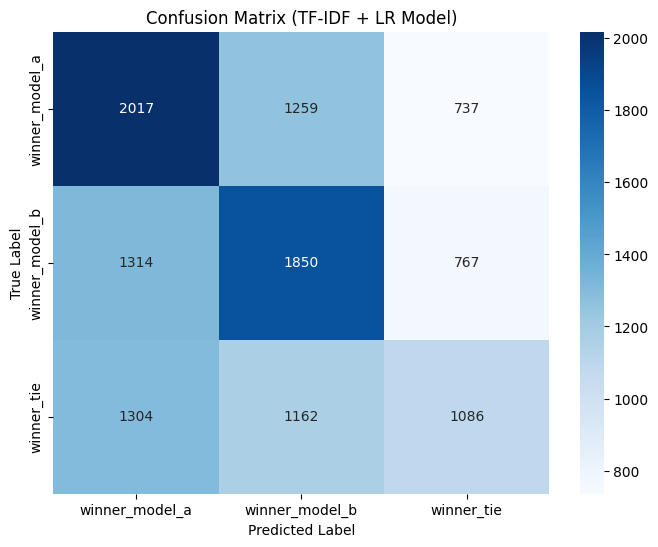


--- 3. 답변 길이(Verbosity) 편향성 분석 ---
답변 길이 차이에 따른 정확도 (A 길이 - B 길이):
len_diff_bin
B >> A (B가 훨씬 김)    0.437021
B > A (B가 김)        0.391878
A ≈ B (비슷함)         0.551724
A > B (A가 김)        0.402256
A >> B (A가 훨씬 김)    0.436407
Name: is_correct, dtype: float64

--- 4. 질적 분석 (주요 오분류 샘플) ---

가장 빈번한 오류 유형 5가지 (실제값 -> 예측값):
y_true          y_pred        
winner_model_b  winner_model_a    1314
winner_tie      winner_model_a    1304
winner_model_a  winner_model_b    1259
winner_tie      winner_model_b    1162
winner_model_b  winner_tie         767
dtype: int64

--- [가장 흔한 오류] 'winner_model_b' -> 'winner_model_a' 샘플 3개 ---

--- 예시 1 ---
PROMPT: ["Write KPI  objectives and KPI strategies for Move all companies ISO processes to new ERP "]...
TRUE: winner_model_b, PRED: winner_model_a
RESPONSE A (길이: 1527): ["Here are some sample KPI objectives and strategies for moving all company ISO processes to a new ERP system:\n\nKPI Objectives:\n- Complete data migration from legacy systems to new ERP with

/tmp/ipython-input-1349191537.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(analysis_df.groupby('len_diff_bin')['is_correct'].mean())


In [28]:
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


print("--- 기존 변수를 사용하여 예측값을 생성합니다 ---")
try:
    y_pred = model_tfidf.predict(X_val_tfidf)
    print("예측 생성 완료.")

except NameError as e:
    print(f"오류: {e}")
    print("이 코드를 실행하기 전에 'model_tfidf', 'X_val_tfidf', 'y_val', 'df_val' 변수가 정의되어 있는지 확인하세요.")
    raise e

print("\n--- 2. 정량 분석 (Classification Report & Confusion Matrix) ---")

class_names = ['winner_model_a', 'winner_model_b', 'winner_tie']

print("Classification Report:")
print(metrics.classification_report(y_val, y_pred, target_names=class_names))

cm = metrics.confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TF-IDF + LR Model)')
plt.savefig('confusion_matrix_tfidf.png')
print("\nConfusion matrix(혼동 행렬)가 'confusion_matrix_tfidf.png' 파일로 저장되었습니다.")
plt.show()


print("\n--- 3. 답변 길이(Verbosity) 편향성 분석 ---")

analysis_df = df_val.copy()
analysis_df['y_true'] = y_val
analysis_df['y_pred'] = y_pred
analysis_df['is_correct'] = (analysis_df['y_true'] == analysis_df['y_pred'])

analysis_df['len_response_a'] = analysis_df['response_a'].str.len()
analysis_df['len_response_b'] = analysis_df['response_b'].str.len()

analysis_df['len_diff'] = analysis_df['len_response_a'] - analysis_df['len_response_b']

bins = [-np.inf, -100, -1, 1, 100, np.inf]
labels = ['B >> A (B가 훨씬 김)', 'B > A (B가 김)', 'A ≈ B (비슷함)', 'A > B (A가 김)', 'A >> B (A가 훨씬 김)']
analysis_df['len_diff_bin'] = pd.cut(analysis_df['len_diff'], bins=bins, labels=labels, right=False)

print("답변 길이 차이에 따른 정확도 (A 길이 - B 길이):")
print(analysis_df.groupby('len_diff_bin')['is_correct'].mean())


print("\n--- 4. 질적 분석 (주요 오분류 샘플) ---")

misclassified_df = analysis_df[analysis_df['is_correct'] == False]

label_to_name_map = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}

print("\n가장 빈번한 오류 유형 5가지 (실제값 -> 예측값):")
error_counts = misclassified_df.groupby(['y_true', 'y_pred']).size().nlargest(5)
error_counts.index = error_counts.index.map(lambda x: (label_to_name_map[x[0]], label_to_name_map[x[1]]))
print(error_counts)


if not error_counts.empty:
    most_common_true_label_name, most_common_pred_label_name = error_counts.index[0]

    name_to_label_map = {v: k for k, v in label_to_name_map.items()}
    most_common_true_label = name_to_label_map[most_common_true_label_name]
    most_common_pred_label = name_to_label_map[most_common_pred_label_name]

    common_errors_df = misclassified_df[
        (misclassified_df['y_true'] == most_common_true_label) &
        (misclassified_df['y_pred'] == most_common_pred_label)
    ]

    print(f"\n--- [가장 흔한 오류] '{most_common_true_label_name}' -> '{most_common_pred_label_name}' 샘플 3개 ---")
    for i, row in enumerate(common_errors_df.head(3).itertuples()):
        print(f"\n--- 예시 {i+1} ---")
        print(f"PROMPT: {row.prompt[:300]}...")
        print(f"TRUE: {label_to_name_map[row.y_true]}, PRED: {label_to_name_map[row.y_pred]}")
        print(f"RESPONSE A (길이: {row.len_response_a}): {row.response_a[:300]}...")
        print(f"RESPONSE B (길이: {row.len_response_b}): {row.response_b[:300]}...")
        print("-" * 30)
else:
    print("\n오분류된 샘플이 없습니다.")